<a href="https://colab.research.google.com/github/DMXMax/covid19/blob/gc_20200315/coviddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests,json
import datetime


In [0]:
covidtrackingurl = "https://covidtracking.com/api/states/daily"
response = requests.get(covidtrackingurl)
dfCovidtracking = pd.DataFrame(response.json())
dfCovidtracking.fillna(0, inplace=True)
dfCovidtracking.negative = dfCovidtracking.negative.astype('int64')
dfCovidtracking.positive = dfCovidtracking.positive.astype('int64')
dfCovidtracking.pending = dfCovidtracking.pending.astype('int64')
dfCovidtracking.total = dfCovidtracking.total.astype('int64')
dfCovidtracking.death = dfCovidtracking.death.astype('int64')

dfCovidtracking.date = dfCovidtracking.date.transform(lambda x: pd.to_datetime(datetime.date(x//10000, x%10000//100, x%100
                                          )))


In [0]:
dfWHO = pd.read_csv("https://raw.githubusercontent.com/DMXMax/covid19/master/who/who_data.tsv",
                     sep='\t', index_col='Date')

In [0]:
jhurl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"+\
"csse_covid_19_data/csse_covid_19_daily_reports/04-24-2020.csv"


dfJHUData = pd.read_csv(jhurl, header=0,
                        names=['FIPS', 'city','state', 'country', 'last_update',
                               'lat', 'lon','confirmed', 'dead', 'recovered','active', 'key'])

In [0]:
dfWHO = dfWHO.rename(columns={"Confirmed": "confirmed", "Deaths": "who_deaths"})
dfWHO.index.names=['date']


In [46]:
dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(),\
  ['state', 'positive', 'negative', 'totalTestResults']].sort_values(by='positive', ascending=False).head(10)

,state,positive,negative,totalTestResults
37,NY,271590,459066,730656.0
34,NJ,102196,103766,205962.0
21,MA,46023,149053,195076.0
16,IL,39658,149974,189632.0
5,CA,39254,454919,494173.0
41,PA,38652,147491,186143.0
24,MI,36641,99655,136296.0
10,FL,30174,286785,316959.0
20,LA,26140,117576,143716.0
7,CT,23921,50117,74038.0


In [0]:
gbUSA = dfCovidtracking.groupby(['date'])
gbCA = dfCovidtracking[dfCovidtracking.state=='CA'].groupby(['date'])

dfUSAPos = gbUSA[['positive', 'totalTestResults', 'death', 'positiveIncrease','deathIncrease']].sum().reset_index().copy()
dfCAPos = gbCA[['positive', 'totalTestResults', 'death','positiveIncrease', 'deathIncrease']].sum().reset_index().copy()

#This will calculate the percentage each day is of the total. In a flattening, this will be more even
# In a high growth situation, you'll higher percentages at the tail. 
dfUSAPos['PCT']= dfUSAPos.positive/dfUSAPos.max().positive
dfCAPos['PCT']=dfCAPos.positive/dfCAPos.max().positive

In [48]:
dfUSAPos[-14:]

,date,positive,totalTestResults,death,positiveIncrease,deathIncrease,PCT
80,2020-04-11,522736,2665559.0,20423,29878.0,1935.0,0.586806
81,2020-04-12,551953,2806019.0,21919,29217.0,1496.0,0.619604
82,2020-04-13,576902,2935134.0,23369,24949.0,1450.0,0.647611
83,2020-04-14,602676,3081589.0,25668,25774.0,2299.0,0.676544
84,2020-04-15,633010,3243109.0,28160,30334.0,2492.0,0.710596
85,2020-04-16,663767,3401571.0,30296,30757.0,2136.0,0.745122
86,2020-04-17,694986,3557959.0,32365,31219.0,2069.0,0.780168
87,2020-04-18,722566,3698918.0,34139,27580.0,1774.0,0.811128
88,2020-04-19,749486,3866147.0,35793,26920.0,1654.0,0.841348
89,2020-04-20,773020,4004047.0,37321,23534.0,1528.0,0.867766


In [49]:
dfCAPos[-7:]

,date,positive,totalTestResults,death,positiveIncrease,deathIncrease,PCT
45,2020-04-18,28963,259666.0,1072,1435.0,87.0,0.737836
46,2020-04-19,30333,280900.0,1166,1370.0,94.0,0.772737
47,2020-04-20,30978,290500.0,1208,645.0,42.0,0.789168
48,2020-04-21,33261,300100.0,1268,2283.0,60.0,0.847328
49,2020-04-22,35396,465327.0,1354,2135.0,86.0,0.901717
50,2020-04-23,37369,482097.0,1469,1973.0,115.0,0.951979
51,2020-04-24,39254,494173.0,1562,1885.0,93.0,1.000000


In [50]:
gbUSA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-04-20,773020,3231027,4037,55509.0,82879.0,14691.0,2193.0,5567.0,214.0,54438.0,37321,82879.0,4008084,4004047.0,4004047.0,1528.0,1998.0,114366.0,23534.0,137900.0
2020-04-21,800305,3355282,3956,58468.0,84292.0,15228.0,2315.0,5514.0,214.0,58117.0,39995,84292.0,4159543,4155587.0,4155587.0,2674.0,1413.0,124255.0,27285.0,151540.0
2020-04-22,827963,3641232,4191,58173.0,85543.0,15341.0,2370.0,5474.0,227.0,61519.0,42128,85543.0,4473386,4469195.0,4469195.0,2133.0,1251.0,285950.0,27658.0,313608.0
2020-04-23,859318,3800932,4258,57879.0,91108.0,15163.0,2428.0,5464.0,227.0,63547.0,44014,91108.0,4664508,4660250.0,4660250.0,1886.0,5601.0,159700.0,31355.0,191055.0
2020-04-24,890816,3992986,4396,56118.0,93107.0,15078.0,2468.0,5187.0,227.0,80958.0,45786,93107.0,4888198,4883802.0,4883802.0,1772.0,1999.0,192054.0,31498.0,223552.0


In [51]:
gbCA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-04-20,30978,259522,0,4674.0,0.0,1480.0,0.0,0.0,0.0,0.0,1208,0.0,290500,290500.0,290500.0,42.0,0.0,8955.0,645.0,9600.0
2020-04-21,33261,266839,0,4886.0,0.0,1502.0,0.0,0.0,0.0,0.0,1268,0.0,300100,300100.0,300100.0,60.0,0.0,7317.0,2283.0,9600.0
2020-04-22,35396,429931,0,4984.0,0.0,1551.0,0.0,0.0,0.0,0.0,1354,0.0,465327,465327.0,465327.0,86.0,0.0,163092.0,2135.0,165227.0
2020-04-23,37369,444728,0,4929.0,0.0,1531.0,0.0,0.0,0.0,0.0,1469,0.0,482097,482097.0,482097.0,115.0,0.0,14797.0,1973.0,16770.0
2020-04-24,39254,454919,0,4880.0,0.0,1521.0,0.0,0.0,0.0,0.0,1562,0.0,494173,494173.0,494173.0,93.0,0.0,10191.0,1885.0,12076.0


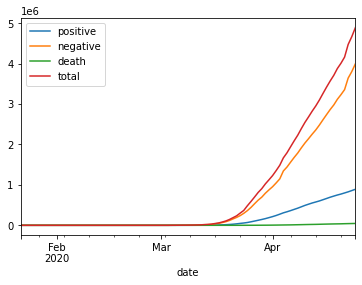

In [52]:
x=gbUSA.sum().loc[:, ['positive', 'negative','death','total']].plot.line()

In [53]:
dfWHO[-14:]

,confirmed,who_deaths
date,,
2020-04-11,461275,16596
2020-04-12,492881,18516
2020-04-13,524514,20444
2020-04-14,553822,21972
2020-04-15,578268,23476
2020-04-16,604070,25871
2020-04-17,632781,28221
2020-04-18,665330,30384
2020-04-19,695353,32427


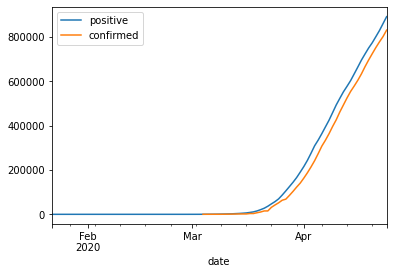

In [54]:
dfResults = gbUSA.sum().join(dfWHO, how='left', rsuffix='_who' )
dfResults.loc[:, ['positive', 'confirmed']].plot.line()

In [55]:
gbCA.sum()[-7:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-04-18,28963,230703,7200,4936.0,0.0,1490.0,0.0,0.0,0.0,0.0,1072,0.0,266866,259666.0,259666.0,87.0,0.0,6617.0,1435.0,8052.0
2020-04-19,30333,250567,7200,4731.0,0.0,1457.0,0.0,0.0,0.0,0.0,1166,0.0,288100,280900.0,280900.0,94.0,0.0,19864.0,1370.0,21234.0
2020-04-20,30978,259522,0,4674.0,0.0,1480.0,0.0,0.0,0.0,0.0,1208,0.0,290500,290500.0,290500.0,42.0,0.0,8955.0,645.0,9600.0
2020-04-21,33261,266839,0,4886.0,0.0,1502.0,0.0,0.0,0.0,0.0,1268,0.0,300100,300100.0,300100.0,60.0,0.0,7317.0,2283.0,9600.0
2020-04-22,35396,429931,0,4984.0,0.0,1551.0,0.0,0.0,0.0,0.0,1354,0.0,465327,465327.0,465327.0,86.0,0.0,163092.0,2135.0,165227.0
2020-04-23,37369,444728,0,4929.0,0.0,1531.0,0.0,0.0,0.0,0.0,1469,0.0,482097,482097.0,482097.0,115.0,0.0,14797.0,1973.0,16770.0
2020-04-24,39254,454919,0,4880.0,0.0,1521.0,0.0,0.0,0.0,0.0,1562,0.0,494173,494173.0,494173.0,93.0,0.0,10191.0,1885.0,12076.0


In [56]:
dfJHUData[dfJHUData.country=='US'][['confirmed', 'dead']].sum()

confirmed    905333
dead          51949
dtype: int64

In [57]:
dfJHUData[(dfJHUData.country=='US')&(dfJHUData.state=='California')][['confirmed', 'dead']].sum()

confirmed    41355
dead          1621
dtype: int64

In [0]:
dfJHUUS = dfJHUData[dfJHUData.country=='US']
gbJHUByState= dfJHUUS.groupby(by='state')
gbJHUByCountry = dfJHUData.groupby(by='country')

In [59]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(10)

country
US                905333
Spain             219764
Italy             192994
France            159952
Germany           154999
United Kingdom    144640
Turkey            104912
Iran               88194
China              83899
Russia             68622
Name: confirmed, dtype: int64

In [0]:
dfData = dfCovidtracking.groupby('date')

In [0]:
dfStateTotal = dfCovidtracking[['state', 'positive']].groupby(by='state').max() \
.rename(columns={'positive':'current_total'})


In [0]:
dfState = dfCovidtracking[['date','state','positive', 'death']].set_index('state') \
  .join(dfStateTotal)

In [0]:
dfState['pct']=dfState.positive/dfState.current_total

In [64]:
dfState.loc['FL'].head(7)

,date,positive,death,current_total,pct
state,,,,,
FL,2020-04-24,30174,1031,30174,1.000000
FL,2020-04-23,28832,979,30174,0.955525
FL,2020-04-22,28309,910,30174,0.938192
FL,2020-04-21,27495,856,30174,0.911215
FL,2020-04-20,26660,806,30174,0.883542
FL,2020-04-19,25996,781,30174,0.861536
FL,2020-04-18,25269,754,30174,0.837443


In [0]:
res = dfState.reset_index().pivot(index = 'date', columns='state', values='pct').fillna(0)

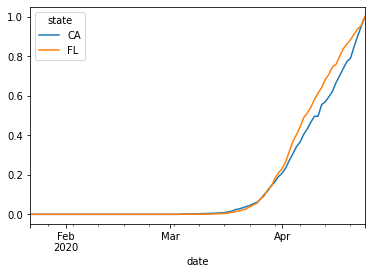

In [66]:
x = res.loc[:, ['CA','FL']].plot.line()

In [0]:
dfNYTesting = dfCovidtracking.loc[dfCovidtracking.state=='NY', ['date', 'negative']].set_index('date')

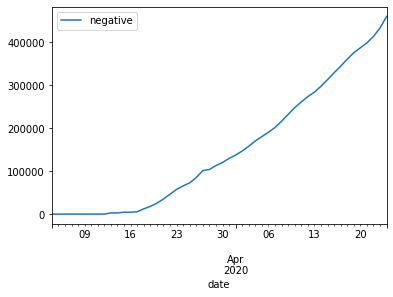

In [68]:
x = dfNYTesting.plot.line()

In [69]:
dfDates = dfState.reset_index().copy()
dfDates[(dfDates.state.isin(['FL']))].head(10)

,state,date,positive,death,current_total,pct
494,FL,2020-04-24,30174,1031,30174,1.000000
495,FL,2020-04-23,28832,979,30174,0.955525
496,FL,2020-04-22,28309,910,30174,0.938192
497,FL,2020-04-21,27495,856,30174,0.911215
498,FL,2020-04-20,26660,806,30174,0.883542
499,FL,2020-04-19,25996,781,30174,0.861536
500,FL,2020-04-18,25269,754,30174,0.837443
501,FL,2020-04-17,24119,699,30174,0.799331
502,FL,2020-04-16,22897,646,30174,0.758832
503,FL,2020-04-15,22511,609,30174,0.746040


In [70]:
datecutoff = dfDates.date.max()-datetime.timedelta(days=3)
dfDates[(dfDates.date == datecutoff) & (dfDates.pct < .7)].sort_values(by='pct')


,state,date,positive,death,current_total,pct


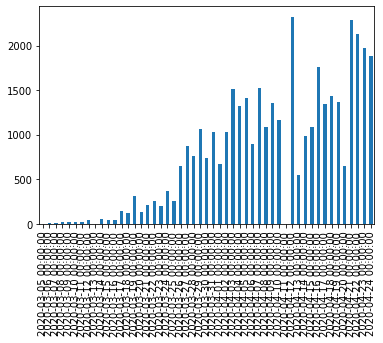

In [71]:
state = 'CA'
dfState = dfCovidtracking[dfCovidtracking.state==state].sort_values(by='date')
vals = dfState.positive.values

x=pd.Series([y-x for x,y in zip(vals,vals[1:])], \
          index = dfCovidtracking[dfCovidtracking.state==state]\
          .sort_values(by='date').date.values[1:] ) \
          .plot.bar()



# Added State Data

In [0]:
data_url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv"


In [0]:
dfUSPop = pd.read_csv(data_url)

In [74]:
us_pop = dfUSPop.loc[0].POPESTIMATE2019 #Estimate from Wikipedia
res = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(), ['positive', 'negative', 'pending','death', 'total']].sum()
print(res)
print(f"Current Infection Rate {res.positive/res.total*100:2f}%")
print(f"Percentage of US affected: {(res.positive+res.death)/us_pop*100:2f}%")
print(f"Percentage of US tested/affected: {(res.negative+res.positive+res.death)/us_pop*100:2f}%")

positive     890816
negative    3992986
pending        4396
death         45786
total       4888198
dtype: int64
Current Infection Rate 18.223812%
Percentage of US affected: 0.285341%
Percentage of US tested/affected: 1.501826%


In [0]:
!if [ ! -d "loc" ]; then \
git clone https://gist.github.com/rogerallen/1583593 --depth=1 --quiet loc; \
fi
import sys
sys.path.append("loc")




In [0]:
import us_state_abbrev as us_abbr


In [0]:
dfStatePop = dfUSPop[dfUSPop.STATE != 0].copy()

In [0]:
dfStatePop['ABBR']=dfStatePop.NAME.apply(lambda x: us_abbr.us_state_abbrev[x])

In [0]:
dfStatePop = dfStatePop.loc[:, ['ABBR', 'POPESTIMATE2019']]
dfStatePop.set_index('ABBR', inplace=True)

In [0]:
dfStateCovid = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max()].set_index('state')

In [0]:
dfStateJoin = dfStateCovid.join(dfStatePop)

In [82]:
pd.DataFrame([(dfStateJoin.positive / dfStateJoin.POPESTIMATE2019)*100, \
              (dfStateJoin.totalTestResults/ dfStateJoin.POPESTIMATE2019)*100],\
             index=['state_pos_pop','state_test_pop'] ).T.sort_values(by="state_pos_pop", ascending=False)[:51]

,state_pos_pop,state_test_pop
state,,
NY,1.396094,3.755898
NJ,1.150572,2.318820
CT,0.670942,2.076635
MA,0.667725,2.830264
RI,0.632362,4.460897
LA,0.562296,3.091468
DC,0.499894,2.342618
MI,0.366892,1.364754
DE,0.353474,1.784724


In [83]:
#print(f"Current Infection Rate {res.positive/res.total*100:2f}%")

print(f"Current Testing Percent {gbUSA.sum().tail(1).totalTestResults[0]/dfUSPop[dfUSPop.REGION=='0'].POPESTIMATE2019[0]*100:2f}%")

Current Testing Percent 1.487877%


In [85]:
dfJHUData.columns

Index(['FIPS', 'city', 'state', 'country', 'last_update', 'lat', 'lon',
       'confirmed', 'dead', 'recovered', 'active', 'key'],
      dtype='object')

In [0]:
dfOwid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

In [87]:
dfOwid.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13261 entries, 0 to 13260
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   iso_code                  13080 non-null  object 
 1   location                  13261 non-null  object 
 2   date                      13261 non-null  object 
 3   total_cases               13261 non-null  int64  
 4   new_cases                 13261 non-null  int64  
 5   total_deaths              13261 non-null  int64  
 6   new_deaths                13261 non-null  int64  
 7   total_cases_per_million   12985 non-null  float64
 8   new_cases_per_million     12985 non-null  float64
 9   total_deaths_per_million  12985 non-null  float64
 10  new_deaths_per_million    12985 non-null  float64
 11  total_tests               3144 non-null   float64
 12  new_tests                 2804 non-null   float64
 13  total_tests_per_thousand  3144 non-null   float64
 14  new_te

In [88]:
dfOwid.date.min()

'2019-12-31'

In [89]:
dfOwid.date.max()

'2020-04-25'

In [0]:
dfOwidTests = dfOwid.dropna(subset=['total_tests']).copy()

In [93]:
dfOwidTests.date.max()

'2020-04-25'

In [94]:
dfOwidTests.head()


,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
440,ARG,Argentina,2020-04-08,1715,87,60,7,37.946,1.925,1.328,0.155,13330.0,NaN,0.293,NaN,tests performed
441,ARG,Argentina,2020-04-09,1795,80,65,5,39.716,1.770,1.438,0.111,14850.0,1520.0,0.326,0.033,tests performed
442,ARG,Argentina,2020-04-10,1894,99,79,14,41.907,2.190,1.748,0.310,16379.0,1529.0,0.360,0.034,tests performed
443,ARG,Argentina,2020-04-11,1975,81,82,3,43.699,1.792,1.814,0.066,18027.0,1648.0,0.396,0.036,tests performed
445,ARG,Argentina,2020-04-13,2203,66,95,6,48.743,1.460,2.102,0.133,19758.0,NaN,0.434,NaN,tests performed


In [0]:
dfOwidLatest = dfOwidTests.sort_values(by='date').groupby('iso_code').last()

In [129]:
dfOwidLatest.total_tests.sort_values(ascending=False)

iso_code
USA    4883802.0
RUS    2721500.0
DEU    2072669.0
ITA    1707743.0
ESP     930230.0
         ...    
CRI       8748.0
PRY       7307.0
SEN       7076.0
MMR       5775.0
BOL       5297.0
Name: total_tests, Length: 78, dtype: float64

In [117]:
isUSA = dfOwidLatest.index.isin(['USA'])
NonUSTests = dfOwidLatest[~isUSA].total_tests.sum()
USTests = dfOwidLatest[isUSA].total_tests.sum()

print(f"Total testing done outside of USA: {NonUSTests:.0f}")
print(f"Total tests done in USA : {USTests:.0f}")
print(f"How many more times has the world tested more than the US: {NonUSTests/USTests:.1f}")

Total testing done outside of USA: 17854563
Total tests done in USA : 4883802
How many more times has the world tested more than the US: 3.7


In [125]:
dfOwid.iso_code.nunique()

206

In [124]:
dfOwid.head()

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
0,ABW,Aruba,2020-03-13,2,2,0,0,18.733,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,ABW,Aruba,2020-03-20,4,2,0,0,37.465,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,ABW,Aruba,2020-03-24,12,8,0,0,112.395,74.930,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,ABW,Aruba,2020-03-25,17,5,0,0,159.227,46.831,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,ABW,Aruba,2020-03-26,19,2,0,0,177.959,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN
